# STAT542 - Mid-term Project

## Hyunjoo Kim (Quantitative Psychology)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 1000)


# Load original data
assessments = pd.read_csv('Data/assessments.csv')
courses = pd.read_csv('Data/courses.csv')
studentassessment = pd.read_csv('Data/studentAssessment.csv')
studentinfo = pd.read_csv('Data/studentInfo.csv')
studentregistration = pd.read_csv('Data/studentRegistration.csv') # For merging two variables with studentinfo
studentVle = pd.read_csv('Data/studentVle.csv') # by id_student
vle = pd.read_csv('Data/vle.csv') # not using

# First, merge student's profiles with their registration information
student_inforeg = pd.merge(studentinfo, studentregistration, how='inner', on=['code_module','code_presentation','id_student'])
student_inforeg.head()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN


# Feature Engineering for 1/3 Module-Period

## Assessment Data

In [2]:
assessments2 = pd.merge(assessments, courses, how='left', on=['code_module', 'code_presentation'])
assessment_total = pd.merge(studentassessment, assessments2, how = 'left', on = 'id_assessment')
assessment_total['date_diff'] = assessment_total['date_submitted'] - assessment_total['date']
assessment_total['module_onethird'] = assessment_total['module_presentation_length']/3

assessment_total_onethird = assessment_total.loc[assessment_total['date']<=assessment_total['module_onethird'],:]
assessment_total_onethird['assignment_failed'] = np.where((assessment_total_onethird['score'] < 40), 1, 0) # remove exams?

assessment_total_onethird_score = assessment_total_onethird.groupby(['code_module','code_presentation','id_student'])['score'].mean()
assessment_total_onethird_date_diff = assessment_total_onethird.groupby(['code_module','code_presentation','id_student'])['date_diff'].mean()
assessment_total_onethird_failed_num = assessment_total_onethird.groupby(['code_module','code_presentation','id_student'])['assignment_failed'].sum()

/var/folders/0x/0qlly95x41d2f03pf55mm_wc0000gn/T/ipykernel_4707/1999267568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessment_total_onethird['assignment_failed'] = np.where((assessment_total_onethird['score'] < 40), 1, 0) # remove exams?


## Vle Data

In [3]:
studentVle_temp = pd.merge(studentVle, assessment_total, how='left', on=['code_module','code_presentation','id_student'])

studentVle_temp_onethird = studentVle_temp.loc[studentVle_temp['date_x'] <= studentVle_temp['module_onethird'],:]
studentVle_temp_onethird_sorted = studentVle_temp_onethird.sort_values(['id_student','id_assessment'])
studentVle_temp_onethird_sorted['assessment_failed'] = np.where(studentVle_temp_onethird_sorted['score'] < 40, 1, 0)

student_idsite = studentVle_temp_onethird_sorted.groupby(['id_student','code_module','code_presentation'])['id_site'].nunique()
student_sum_click_mean = studentVle_temp_onethird_sorted.groupby(['id_student','code_module','code_presentation'])['sum_click'].mean()
student_sum_click_var = studentVle_temp_onethird_sorted.groupby(['id_student','code_module','code_presentation'])['sum_click'].var() # shape:(25,739)

## Merging Assessment and Vle Data

In [4]:
assessment_total_onethird_score = assessment_total_onethird_score.reset_index()
assessment_total_onethird_date_diff = assessment_total_onethird_date_diff.reset_index()
assessment_total_onethird_failed_num = assessment_total_onethird_failed_num.reset_index()

# Merge Assessments(date_submitted_diff_mean, score_mean, assignment_failed_sum)
assessment_total_temp1 = pd.merge(assessment_total_onethird_score, assessment_total_onethird_date_diff, how='left', on=['code_module','code_presentation','id_student'])
assessment_total_temp2 = pd.merge(assessment_total_temp1, assessment_total_onethird_failed_num, how='left', on=['code_module','code_presentation','id_student'])

# Vle(id_site_nunique, sum_click_mean, sum_click_var)
student_idsite = studentVle_temp_onethird_sorted.groupby(['id_student','code_module','code_presentation'])['id_site'].nunique()
student_sum_click_mean = studentVle_temp_onethird_sorted.groupby(['id_student','code_module','code_presentation'])['sum_click'].mean()
student_sum_click_var = studentVle_temp_onethird_sorted.groupby(['id_student','code_module','code_presentation'])['sum_click'].var()

student_idsite = student_idsite.reset_index()
student_sum_click_mean = student_sum_click_mean.reset_index()
student_sum_click_var = student_sum_click_var.reset_index()

vle_total_temp1 = pd.merge(student_idsite, student_sum_click_mean, how='left', on=['code_module','code_presentation','id_student'])
vle_total_temp2 = pd.merge(vle_total_temp1, student_sum_click_var, how='left', on=['code_module','code_presentation','id_student'])

student_total_temp2 = pd.merge(assessment_total_temp2, vle_total_temp2, how='outer', on=['code_module','code_presentation','id_student'])
student_total_temp3 = pd.merge(student_inforeg, student_total_temp2, how='left', on=['code_module','code_presentation','id_student'])

student_total_temp4 = pd.merge(student_total_temp3, courses, how='left', on=['code_module','code_presentation'])

# Remove rows that had unregistered before the class started & rows with date_registration = NaN
student_total_temp4 = student_total_temp4.drop(student_total_temp4[student_total_temp4['date_unregistration'] <= 0].index).reset_index(drop=True)
student_total_temp4 = student_total_temp4.dropna(subset=['date_registration'])

# Remove rows that date_unregisration happend before 1/3 of module length
student_total_temp5 = student_total_temp4[~(student_total_temp4['date_unregistration']<=student_total_temp4['module_presentation_length']/3)].reset_index(drop=True)
student_total_temp5.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,score,date_diff,assignment_failed,id_site,sum_click_x,sum_click_y,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,81.5,-1.0,0.0,37.0,5.435185,85.626589,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,69.0,0.5,0.0,45.0,3.615044,13.416780,268
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,71.5,-2.5,0.0,46.0,3.372014,10.711921,268
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,49.5,14.0,1.0,43.0,3.632979,14.087729,268
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,-110.0,NaN,74.0,5.0,0.0,47.0,3.509934,11.562194,268


In [5]:
# <Nan Values>
# imd_band: The mode of a student's highest_education
# score, id_site, sum_click_x, sum_click_y = 0
# date_diff: 1/3 period of modules
# assignment_failed: max

# A Level or Equivalent: 30-40%
# HE Qualification: 90-100%
# Lower Than A Level: 10-20
# No Formal quals: 20-30%
# Post Graduate Qualification: 90-100%

student_total_temp5['score'] = student_total_temp5['score'].fillna(0)
student_total_temp5['date_diff'] = student_total_temp5['date_diff'].fillna(student_total_temp5['module_presentation_length']/3)
student_total_temp5['assignment_failed'] = student_total_temp5['assignment_failed'].fillna(max(student_total_temp5['assignment_failed']))
student_total_temp5['id_site'] = student_total_temp5['id_site'].fillna(0)
student_total_temp5['sum_click_x'] = student_total_temp5['sum_click_x'].fillna(0)
student_total_temp5['sum_click_y'] = student_total_temp5['sum_click_y'].fillna(0)

student_total_temp5.loc[student_total_temp5['highest_education'] == 'A Level or Equivalent', 'imd_band'] = student_total_temp5.loc[student_total_temp5['highest_education'] == 'A Level or Equivalent', 'imd_band'].fillna('30-40%')
student_total_temp5.loc[student_total_temp5['highest_education'] == 'HE Qualification', 'imd_band'] = student_total_temp5.loc[student_total_temp5['highest_education'] == 'HE Qualification', 'imd_band'].fillna('90-100%')
student_total_temp5.loc[student_total_temp5['highest_education'] == 'Lower Than A Level', 'imd_band'] = student_total_temp5.loc[student_total_temp5['highest_education'] == 'Lower Than A Level', 'imd_band'].fillna('10-20')
student_total_temp5.loc[student_total_temp5['highest_education'] == 'No Formal quals', 'imd_band'] = student_total_temp5.loc[student_total_temp5['highest_education'] == 'No Formal quals', 'imd_band'].fillna('20-30%')
student_total_temp5.loc[student_total_temp5['highest_education'] == 'Post Graduate Qualification', 'imd_band'] = student_total_temp5.loc[student_total_temp5['highest_education'] == 'Post Graduate Qualification', 'imd_band'].fillna('90-100%')

student_total_temp5.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,score,date_diff,assignment_failed,id_site,sum_click_x,sum_click_y,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,81.5,-1.0,0.0,37.0,5.435185,85.626589,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,69.0,0.5,0.0,45.0,3.615044,13.416780,268
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,71.5,-2.5,0.0,46.0,3.372014,10.711921,268
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,49.5,14.0,1.0,43.0,3.632979,14.087729,268
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,-110.0,NaN,74.0,5.0,0.0,47.0,3.509934,11.562194,268


In [6]:
student_total_temp5.isna().sum()

code_module                       0
code_presentation                 0
id_student                        0
gender                            0
region                            0
highest_education                 0
imd_band                          0
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                      0
date_registration                 0
date_unregistration           22515
score                             0
date_diff                         0
assignment_failed                 0
id_site                           0
sum_click_x                       0
sum_click_y                       0
module_presentation_length        0
dtype: int64

## Modeling

In [7]:
student_total_onethird = student_total_temp5.copy()

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score)

In [9]:
# For modeling, 
# code_presentation: J or B
# final_result: Withdrawn-Fail, Distinction-Pass
# drop date_unregistration, module_presentation_length
student_total_onethird['code_presentation'] = student_total_onethird['code_presentation'].agg(lambda x: x[4])
student_total_onethird.loc[student_total_onethird['final_result'] == 'Withdrawn', 'final_result'] = 'Fail'
student_total_onethird.loc[student_total_onethird['final_result'] == 'Distinction', 'final_result'] = 'Pass'

student_total_onethird.drop(['date_unregistration','module_presentation_length'], axis=1, inplace=True)

# collect categorical variables
cates = []
for col in student_total_onethird.columns.values:
    if student_total_onethird[col].dtype == 'object':
        cates.append(col)

# Dummification
def dummify_cols(df, cols):
    return df.join([pd.get_dummies(df[col], prefix=col) for col in cols])

modeling_onethird_dummies = dummify_cols(student_total_onethird,cates[:8])
modeling_onethird_dummies.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,score,date_diff,assignment_failed,id_site,sum_click_x,sum_click_y,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_B,code_presentation_J,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,imd_band_0-10%,imd_band_10-20,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,AAA,J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,81.5,-1.0,0.0,37.0,5.435185,85.626589,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
1,AAA,J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,69.0,0.5,0.0,45.0,3.615044,13.416780,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
2,AAA,J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,71.5,-2.5,0.0,46.0,3.372014,10.711921,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
3,AAA,J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,49.5,14.0,1.0,43.0,3.632979,14.087729,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,AAA,J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,-110.0,74.0,5.0,0.0,47.0,3.509934,11.562194,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0


In [10]:
modeling_onethird_dummies.columns.values

array(['code_module', 'code_presentation', 'id_student', 'gender',
       'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'final_result', 'date_registration', 'score', 'date_diff',
       'assignment_failed', 'id_site', 'sum_click_x', 'sum_click_y',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_B', 'code_presentation_J',
       'gender_F', 'gender_M', 'region_East Anglian Region',
       'region_East Midlands Region', 'region_Ireland',
       'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_educ

In [11]:
# Extract features 
feature_cols = ['num_of_prev_attempts', 'studied_credits',
       'date_registration', 'score', 'date_diff',
       'assignment_failed', 'id_site', 'sum_click_x', 'sum_click_y',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_presentation_B', 'gender_F',
       'region_East Anglian Region',
       'region_East Midlands Region', 'region_Ireland',
       'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals', 'imd_band_0-10%',
       'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%',
       'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%',
       'imd_band_70-80%', 'imd_band_80-90%',
       'age_band_0-35', 'age_band_35-55', 'disability_N']

X_onethird = modeling_onethird_dummies[feature_cols]
Y_onethird = modeling_onethird_dummies['final_result']
X_onethird_train, X_onethird_test, Y_onethird_train, Y_onethird_test = train_test_split(X_onethird, Y_onethird, test_size = 0.2)

### 1. Logistic Regression - Lasso

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline_logisticRegr1 = make_pipeline(
    StandardScaler(),
    LogisticRegression(C = 0.1, penalty='l1', solver='saga')
)
pipeline_logisticRegr1.fit(X_onethird_train, Y_onethird_train)
logisticRegr1_predictions_onethird = pipeline_logisticRegr1.predict(X_onethird_test[feature_cols])

/Users/hyunjookim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [66]:
logisticRegr1_accuracy = accuracy_score(logisticRegr1_predictions_onethird, Y_onethird_test)
logisticRegr1_f1 = f1_score(logisticRegr1_predictions_onethird, Y_onethird_test, average="weighted")

print("LogisticRegr1_Accuracy:", logisticRegr1_accuracy)
print("LogisticRegr1_F1 Score:", logisticRegr1_f1)

LogisticRegr1_Accuracy: 0.743245869776482
LogisticRegr1_F1 Score: 0.7515170400109895


### 2. SVM

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

svm_onethird = svm.SVC()
svm_onethird.fit(X_onethird_train, Y_onethird_train)
svm_predictions_onethird = svm_onethird.predict(X_onethird_test[feature_cols])

In [68]:
svm_accuracy = accuracy_score(svm_predictions_onethird, Y_onethird_test)
svm_f1 = f1_score(svm_predictions_onethird, Y_onethird_test, average="weighted")

print("SVM_Accuracy:", svm_accuracy)
print("SVM_F1 Score:", svm_f1)

SVM_Accuracy: 0.6742468415937803
SVM_F1 Score: 0.7412924459097091


### 3. Decision Tree

In [69]:
from sklearn import tree

dt_onethird = tree.DecisionTreeClassifier()
dt_onethird.fit(X_onethird_train[feature_cols], Y_onethird_train)
dt_predictions_onethird = dt_onethird.predict(X_onethird_test[feature_cols])

In [70]:
dt_accuracy = accuracy_score(dt_predictions_onethird, Y_onethird_test)
dt_f1 = f1_score(dt_predictions_onethird, Y_onethird_test, average="weighted")

print("DT_Accuracy:", dt_accuracy)
print("DT_F1 Score:", dt_f1)

DT_Accuracy: 0.6678328474246842
DT_F1 Score: 0.6676946366693832


In [71]:
# Find better parmeters
hyperparamters = {'max_depth':[1,2,3,5,7,10], 'min_samples_split':[2,3,5,10,20]}
GridCV = GridSearchCV(estimator=dt_onethird, param_grid = hyperparamters, cv=10, verbose=1)
GridCV.fit(X_onethird_train[feature_cols], Y_onethird_train)

GridCV.best_params_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


{'max_depth': 7, 'min_samples_split': 20}

In [72]:
dt_onethird_opt = tree.DecisionTreeClassifier(max_depth=7, min_samples_split=5)
dt_onethird_opt.fit(X_onethird_train[feature_cols], Y_onethird_train)
dt_predictions_onethird_opt = dt_onethird_opt.predict(X_onethird_test[feature_cols])

In [73]:
dt_opt_accuracy = accuracy_score(dt_predictions_onethird_opt, Y_onethird_test)
dt_opt_f1 = f1_score(dt_predictions_onethird_opt, Y_onethird_test, average="weighted")

print("DT_opt_Accuracy:", dt_opt_accuracy)
print("DT_opt_F1 Score:", dt_opt_f1)

DT_opt_Accuracy: 0.7401360544217687
DT_opt_F1 Score: 0.7475356271001963


### 4. Random Forest

In [74]:
rfc_onethird = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_onethird.fit(X_onethird_train[feature_cols], Y_onethird_train)
rfc_predictions_onethird = rfc_onethird.predict(X_onethird_test[feature_cols])

In [75]:
rfc_accuracy = accuracy_score(rfc_predictions_onethird, Y_onethird_test)
rfc_f1 = f1_score(rfc_predictions_onethird, Y_onethird_test, average="weighted")

print("RFC_opt_Accuracy:", rfc_accuracy)
print("RFC_opt_F1 Score:", rfc_f1)

RFC_opt_Accuracy: 0.7541302235179786
RFC_opt_F1 Score: 0.7609293109751183


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'score'),
  Text(1, 0, 'date_diff'),
  Text(2, 0, 'date_registration'),
  Text(3, 0, 'studied_credits'),
  Text(4, 0, 'num_of_prev_attempts')])

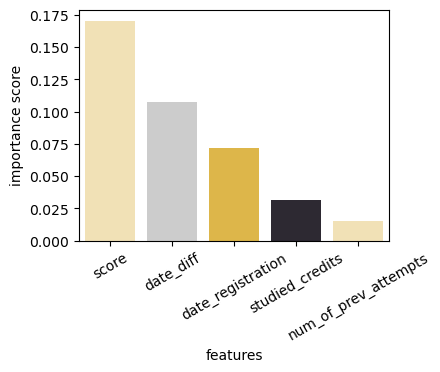

In [76]:
importance_onethird = pd.DataFrame(rfc_onethird.feature_importances_, index = X_onethird_train[feature_cols].columns, columns = ["importance"])
importance_onethird = importance_onethird.reset_index()
importance_onethird.columns = ['features','importance score']

plt.figure(figsize=(4,3))
sns.barplot(x='features', y='importance score', data=importance_onethird[:5].sort_values(by='importance score',ascending=False),palette=["#FBE6AC","#CCCCCC","#F5C132","#2D2833"])
plt.xticks(rotation=30)

### 5. Naive Bayes

In [83]:
import sklearn
from sklearn.naive_bayes import GaussianNB

gnb_onethird = sklearn.naive_bayes.GaussianNB()
gnb_onethird.fit(X_onethird_train[feature_cols], Y_onethird_train)
gnb_predictions_onethird = gnb_onethird.predict(X_onethird_test[feature_cols])

In [84]:
gnb_accuracy = accuracy_score(gnb_predictions_onethird, Y_onethird_test)
gnb_f1 = f1_score(gnb_predictions_onethird, Y_onethird_test, average="weighted")

print("Accuracy:", gnb_accuracy)
print("F1 Score:", gnb_f1)

Accuracy: 0.706511175898931
F1 Score: 0.7214546819280505


### 6. Bayesian Neural Network

In [12]:
Y_onethird_train_bin = Y_onethird_train.copy()
Y_onethird_test_bin = Y_onethird_test.copy()

Y_onethird_train_bin[Y_onethird_train_bin == 'Pass'] = 1.0
Y_onethird_train_bin[Y_onethird_train_bin == 'Fail'] = 0.0
Y_onethird_test_bin[Y_onethird_test_bin == 'Pass'] = 1.0
Y_onethird_test_bin[Y_onethird_test_bin == 'Fail'] = 0.0

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

bnn_onethird = nn.Sequential(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=45, out_features = 3000),
                     nn.ReLU(),
                     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features = 3000, out_features = 2),
                     )

ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1

optimizer = optim.Adam(bnn_onethird.parameters(), lr=0.01)

In [58]:
X_onethird_train_bnn = torch.from_numpy(X_onethird_train.to_numpy()).float()
Y_onethird_train_bin_bnn = torch.from_numpy(Y_onethird_train_bin.to_numpy(dtype=np.float16)).long()

In [59]:
for step in range(5000):
    pre = bnn_onethird(X_onethird_train_bnn)
    ce = ce_loss(pre, Y_onethird_train_bin_bnn)
    kl = kl_loss(bnn_onethird)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = Y_onethird_train_bin_bnn.size(0)
correct = (predicted == Y_onethird_train_bin_bnn).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 67.055450 %
- CE : 0.66, KL : 0.79


In [60]:
X_onethird_test_bnn = torch.from_numpy(X_onethird_test.to_numpy()).float()

bnn_pred_onethird = bnn_onethird(X_onethird_test_bnn)
_, bnn_predictions_onethird = torch.max(bnn_pred_onethird.data, 1)

In [62]:
bnn_predictions_onethird = np.transpose(np.array(bnn_predictions_onethird, dtype='float64'))
Y_onethird_test_bin =np.array(Y_onethird_test_bin,dtype='float64')

In [63]:
bnn_accuracy = accuracy_score(bnn_predictions_onethird, Y_onethird_test_bin)
bnn_f1 = f1_score(bnn_predictions_onethird, Y_onethird_test_bin, average="weighted")

print("Accuracy:", bnn_accuracy)
print("F1 Score:", bnn_f1)

Accuracy: 0.6586977648202138
F1 Score: 0.7087727671602481
